# Neural Network classification with PyTorch

## 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 100 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [4]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


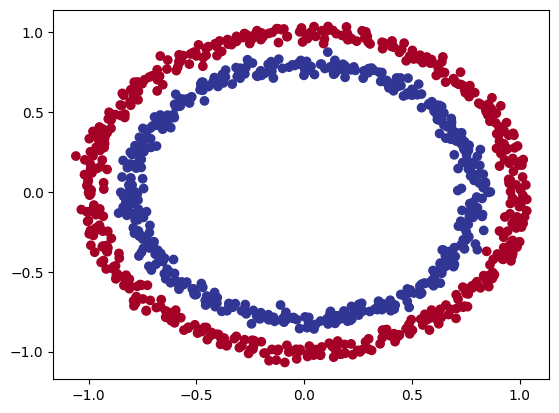

In [5]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensrs and create train and test splits

In [8]:
# Trun data into tensors
import torch
torch.__version__

'2.4.0+cu121'

In [9]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

In [11]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5155,  0.1062],
                      [ 0.5892,  0.4947],
                      [-0.4535, -0.2140],
                      [ 0.5842, -0.5484],
                      [ 0.0101, -0.1500]], device='cuda:0')),
             ('0.bias',
              tensor([-0.2829, -0.1418,  0.0834,  0.6335, -0.5369], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3071, -0.3388, -0.1341, -0.0428,  0.1518]], device='cuda:0')),
             ('1.bias', tensor([0.0964], device='cuda:0'))])

In [15]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n {untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
 tensor([[ 0.1152],
        [-0.0574],
        [ 0.3906],
        [ 0.0379],
        [ 0.1096],
        [ 0.0065],
        [-0.2568],
        [-0.2426],
        [ 0.4021],
        [-0.0720]], device='cuda:0')

First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

In [16]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [17]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) *100
    return acc

## 3. Train model

### 3.1 Going from raw logits -> prediction prbabilities -> prediction labels

In [18]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.1152],
        [-0.0574],
        [ 0.3906],
        [ 0.0379],
        [ 0.1096]], device='cuda:0')

In [19]:
# Use the sigmoid activation function on our model logits to turn them into predicion probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs


tensor([[0.5288],
        [0.4857],
        [0.5964],
        [0.5095],
        [0.5274]], device='cuda:0')

In [20]:
# Find the prediction labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 0., 1., 1., 1.], device='cuda:0')

### Building a training loop

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, # nn.BCEWithLogitLoss expects raw logits as input
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradiant descent)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        # Print out what's happening
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, | Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, | Test acc: {test_acc:.2f}")

    

Epoch: 0 | Loss: 0.70308, | Acc: 51.38% | Test loss: 0.69415, | Test acc: 51.50
Epoch: 10 | Loss: 0.69986, | Acc: 50.75% | Test loss: 0.69259, | Test acc: 51.00
Epoch: 20 | Loss: 0.69798, | Acc: 50.12% | Test loss: 0.69191, | Test acc: 51.00
Epoch: 30 | Loss: 0.69676, | Acc: 50.00% | Test loss: 0.69162, | Test acc: 52.00
Epoch: 40 | Loss: 0.69589, | Acc: 49.88% | Test loss: 0.69152, | Test acc: 51.50
Epoch: 50 | Loss: 0.69525, | Acc: 49.50% | Test loss: 0.69152, | Test acc: 52.00
Epoch: 60 | Loss: 0.69477, | Acc: 49.38% | Test loss: 0.69159, | Test acc: 52.00
Epoch: 70 | Loss: 0.69440, | Acc: 49.50% | Test loss: 0.69170, | Test acc: 52.00
Epoch: 80 | Loss: 0.69411, | Acc: 49.88% | Test loss: 0.69184, | Test acc: 51.00
Epoch: 90 | Loss: 0.69388, | Acc: 49.62% | Test loss: 0.69199, | Test acc: 51.00


## 4. Make predictions and evaluate the model

In [22]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("help_functions.py").is_file():
    print("helper_funcyions.py already exists, skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


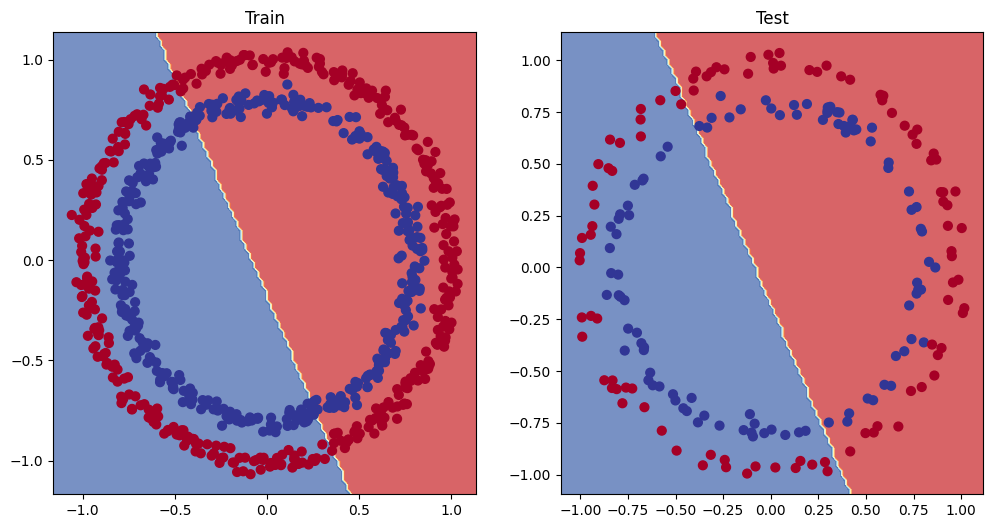

In [23]:
# Plot decision boundary of model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

In [24]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create a optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [26]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate the loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    
    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, | Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, | Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69396, | Acc: 50.88% | Test loss: 0.69261, | Test acc: 51.00
Epoch: 10 | Loss: 0.69369, | Acc: 50.25% | Test loss: 0.69270, | Test acc: 50.00
Epoch: 20 | Loss: 0.69351, | Acc: 50.12% | Test loss: 0.69283, | Test acc: 49.50
Epoch: 30 | Loss: 0.69339, | Acc: 50.50% | Test loss: 0.69297, | Test acc: 48.00
Epoch: 40 | Loss: 0.69329, | Acc: 50.38% | Test loss: 0.69310, | Test acc: 49.00
Epoch: 50 | Loss: 0.69322, | Acc: 49.88% | Test loss: 0.69324, | Test acc: 50.00
Epoch: 60 | Loss: 0.69317, | Acc: 49.38% | Test loss: 0.69336, | Test acc: 51.50
Epoch: 70 | Loss: 0.69312, | Acc: 49.38% | Test loss: 0.69348, | Test acc: 50.50
Epoch: 80 | Loss: 0.69309, | Acc: 50.12% | Test loss: 0.69359, | Test acc: 50.00
Epoch: 90 | Loss: 0.69307, | Acc: 50.50% | Test loss: 0.69370, | Test acc: 48.50
Epoch: 100 | Loss: 0.69305, | Acc: 50.38% | Test loss: 0.69379, | Test acc: 48.00
Epoch: 110 | Loss: 0.69303, | Acc: 50.88% | Test loss: 0.69388, | Test acc: 46.50
Epoch: 120 | Loss: 0.69302,

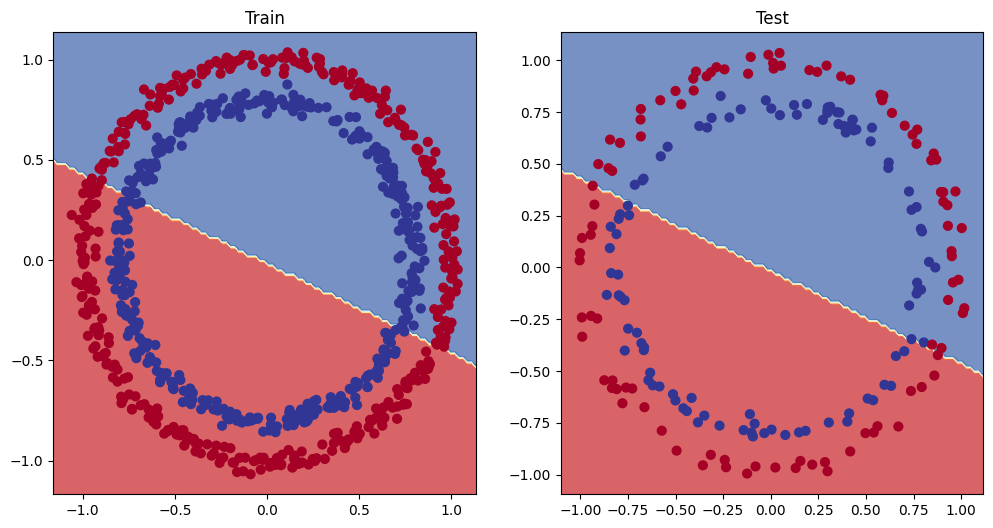

In [27]:
# Plot decision boundary of model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

In [28]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [29]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(X_test_regression), len(y_test_regression)

(80, 20, 20, 20)

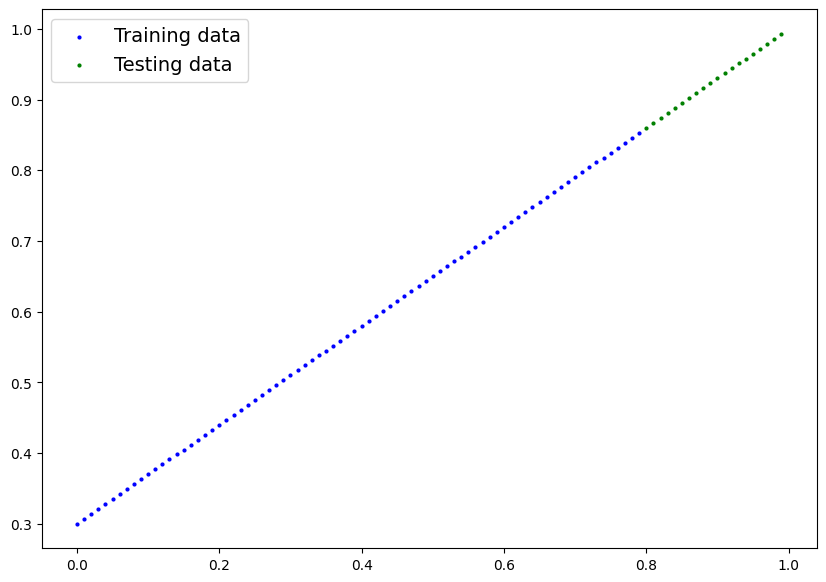

In [30]:
plot_predictions(train_data=X_train_regression, 
                train_labels=y_train_regression, 
                test_data=X_test_regression, 
                test_labels=y_test_regression)

### 5.2 Adjusting 'model_1' to fit a straight line

In [31]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)

In [32]:
# loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [33]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

# Put data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(y_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)
    
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")


Epoch: 0 | Loss: 0.75986 | Test loss: 0.90089
Epoch: 1 | Loss: 0.72202 | Test loss: 0.85824
Epoch: 2 | Loss: 0.68479 | Test loss: 0.81614
Epoch: 3 | Loss: 0.64812 | Test loss: 0.77452
Epoch: 4 | Loss: 0.61194 | Test loss: 0.73331
Epoch: 5 | Loss: 0.57621 | Test loss: 0.69245
Epoch: 6 | Loss: 0.54087 | Test loss: 0.65187
Epoch: 7 | Loss: 0.50587 | Test loss: 0.61153
Epoch: 8 | Loss: 0.47116 | Test loss: 0.57135
Epoch: 9 | Loss: 0.43668 | Test loss: 0.53129
Epoch: 10 | Loss: 0.40240 | Test loss: 0.49129
Epoch: 11 | Loss: 0.36827 | Test loss: 0.45128
Epoch: 12 | Loss: 0.33423 | Test loss: 0.41122
Epoch: 13 | Loss: 0.30024 | Test loss: 0.37104
Epoch: 14 | Loss: 0.26625 | Test loss: 0.33070
Epoch: 15 | Loss: 0.23222 | Test loss: 0.29013
Epoch: 16 | Loss: 0.19811 | Test loss: 0.24928
Epoch: 17 | Loss: 0.16386 | Test loss: 0.20810
Epoch: 18 | Loss: 0.12943 | Test loss: 0.16652
Epoch: 19 | Loss: 0.09478 | Test loss: 0.12450
Epoch: 20 | Loss: 0.06007 | Test loss: 0.08416
Epoch: 21 | Loss: 0.035

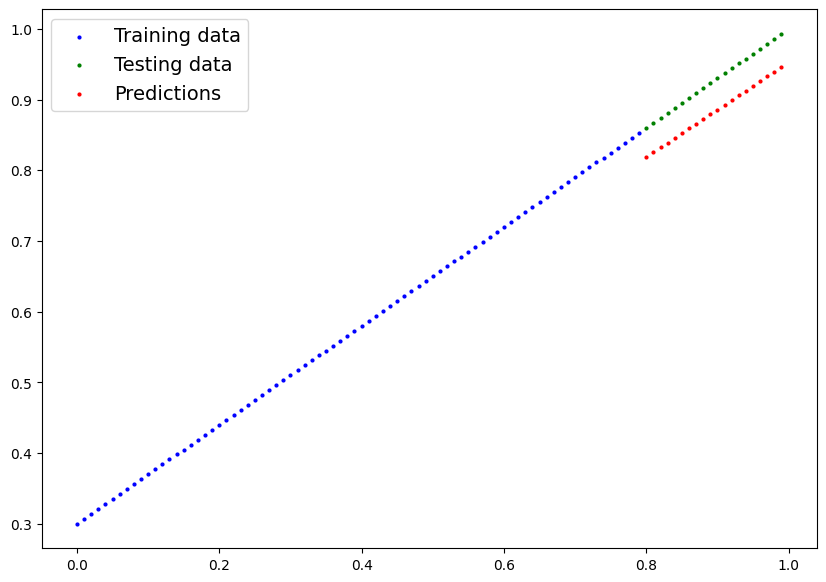

In [34]:
# Turn on evaluation mode
model_2.eval()

#Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

## 6. The missing piece: non-linearity

In [35]:
from sklearn.datasets import make_circles

# Make 100 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [36]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

### 6.2 Building a model with non-linearity

In [37]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [38]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    ### Training
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6929, Acc: 50.00% | Test Loss: 0.6932, Test Acc: 50.00%
Epoch: 100 | Loss: 0.6912, Acc: 52.88% | Test Loss: 0.6910, Test Acc: 52.50%
Epoch: 200 | Loss: 0.6898, Acc: 53.37% | Test Loss: 0.6894, Test Acc: 55.00%
Epoch: 300 | Loss: 0.6879, Acc: 53.00% | Test Loss: 0.6872, Test Acc: 56.00%
Epoch: 400 | Loss: 0.6852, Acc: 52.75% | Test Loss: 0.6841, Test Acc: 56.50%
Epoch: 500 | Loss: 0.6810, Acc: 52.75% | Test Loss: 0.6794, Test Acc: 56.50%
Epoch: 600 | Loss: 0.6751, Acc: 54.50% | Test Loss: 0.6729, Test Acc: 56.00%
Epoch: 700 | Loss: 0.6666, Acc: 58.38% | Test Loss: 0.6632, Test Acc: 59.00%
Epoch: 800 | Loss: 0.6516, Acc: 64.00% | Test Loss: 0.6476, Test Acc: 67.50%
Epoch: 900 | Loss: 0.6236, Acc: 74.00% | Test Loss: 0.6215, Test Acc: 79.00%


### 6.4 Evaluating a model trained with non-linear activation functions

In [40]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

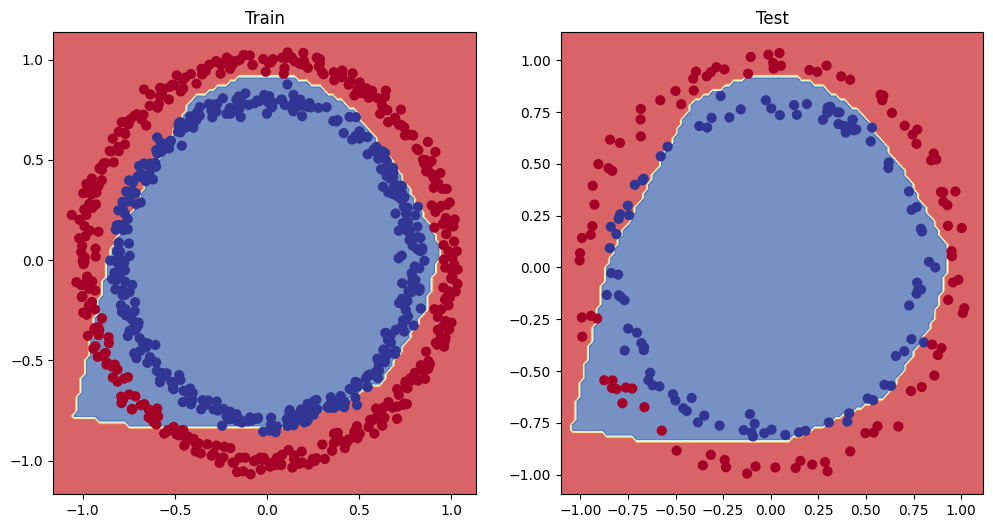

In [41]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

In [42]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [43]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

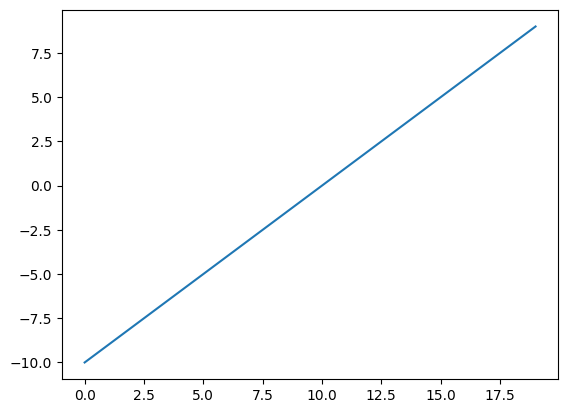

In [44]:
# Visualize the tensor
plt.plot(A)

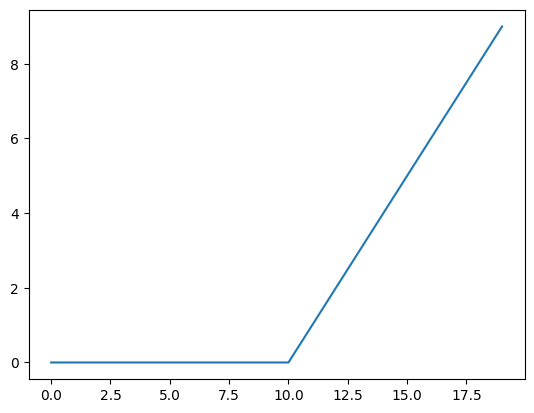

In [45]:
plt.plot(torch.relu(A))

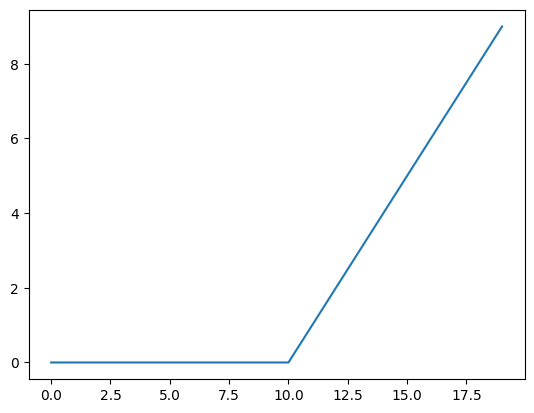

In [46]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) # inputs must be tensors
plt.plot(relu(A))

In [47]:
# for Sigmoid
def sigmoid(x):
    return 1 / (1+torch.exp(-x))

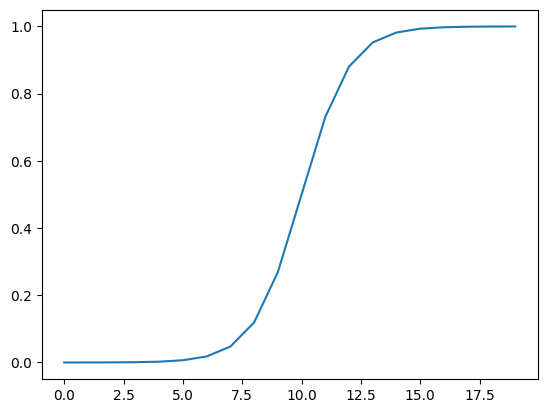

In [48]:
plt.plot(torch.sigmoid(A))

## 8. Putting it all together with a multi-class classiication problem

### 8.1 Creating a toy multi-class dataset

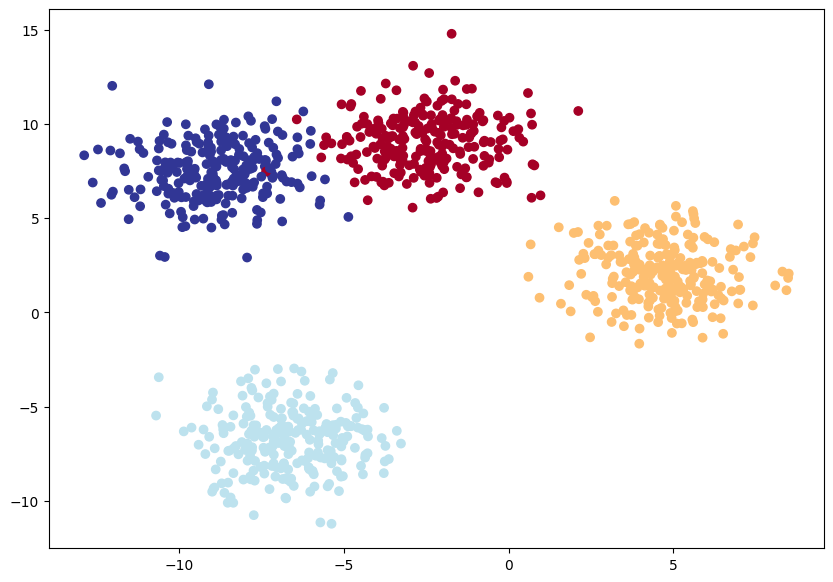

In [72]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,n_features=NUM_FEATURES, centers = NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)


### 8.2 Building a multi-class classification model in PyTorch

In [73]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [74]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes multi-class classfication model.
        
        Args:
            input_features (int): number of input features to the model
            output_features (int): Number of outputs features (number of output classes)
            hidden_units (int): Number of hidden units between layers, deafult 8
        
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self,x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [75]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [76]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.3 Create a loss function and an optimizer for a multi-class classification model

In [77]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create a optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

Logits (raw output of the model) -> Pred probs (use 'torch.softmax') -> Pred labels (take the argmax of the prediction probabilities)

In [78]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))
y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [79]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [80]:
# Convert out model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [81]:
# Convert our model's prediciton probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [82]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [84]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
    ### Training
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred = y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.0636, Acc: 54.62% | Test Loss: 1.0039, Test Acc: 55.00%
Epoch: 10 | Loss: 0.6210, Acc: 97.25% | Test Loss: 0.6367, Test Acc: 98.00%
Epoch: 20 | Loss: 0.4061, Acc: 98.75% | Test Loss: 0.4104, Test Acc: 100.00%
Epoch: 30 | Loss: 0.2362, Acc: 99.12% | Test Loss: 0.2268, Test Acc: 99.50%
Epoch: 40 | Loss: 0.1044, Acc: 99.25% | Test Loss: 0.0949, Test Acc: 99.50%
Epoch: 50 | Loss: 0.0640, Acc: 99.25% | Test Loss: 0.0563, Test Acc: 99.50%
Epoch: 60 | Loss: 0.0497, Acc: 99.25% | Test Loss: 0.0419, Test Acc: 99.50%
Epoch: 70 | Loss: 0.0424, Acc: 99.25% | Test Loss: 0.0343, Test Acc: 99.50%
Epoch: 80 | Loss: 0.0380, Acc: 99.25% | Test Loss: 0.0295, Test Acc: 99.50%
Epoch: 90 | Loss: 0.0350, Acc: 99.25% | Test Loss: 0.0264, Test Acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [85]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-0.6257,  6.0063, -7.6488, -8.4666],
        [-2.1813, -6.3889, -3.7303,  3.1376],
        [-3.4241, -3.9088,  3.1701, -2.6211],
        [-1.1539,  4.2110, -3.8565, -4.8926],
        [ 3.7713, -1.3379, -9.1623, -6.9665],
        [-2.8284, -7.5936, -4.3072,  3.8118],
        [-3.0427, -3.3442,  2.8070, -2.1454],
        [ 3.3902, -4.0445, -6.9149, -3.5610],
        [-4.3793, -5.0066,  3.8291, -3.3930],
        [ 3.5159, -3.0320, -7.5575, -4.7203]], device='cuda:0')

In [86]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


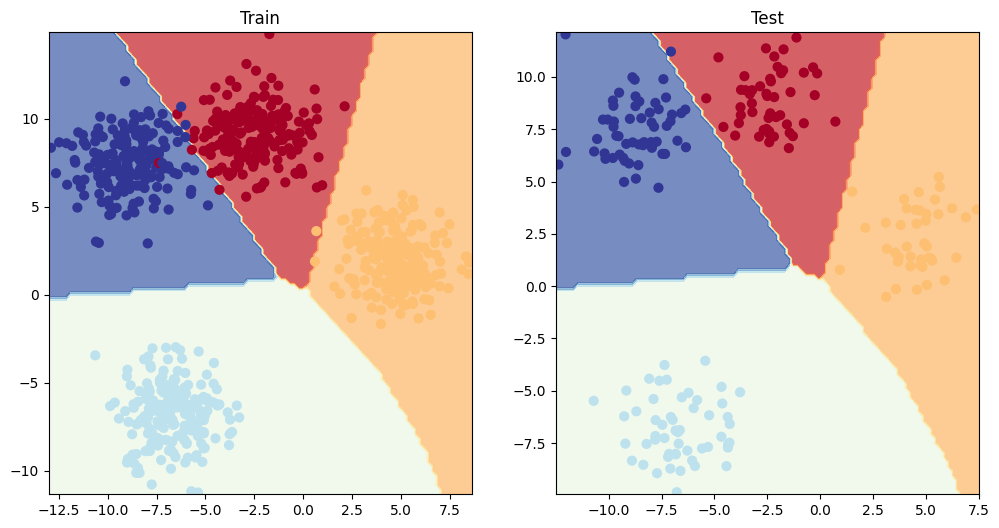

In [87]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)